# Restricted Distance Calculation

In [1]:
from itertools import combinations

import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra

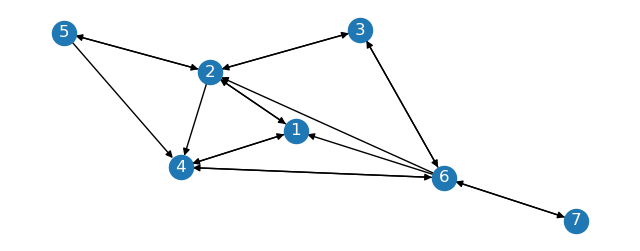

In [2]:
# Create graph
G = nx.DiGraph(
    [
        (1, 2, {"weight": 1}),
        (2, 1, {"weight": 1}),
        (2, 3, {"weight": 1}),
        (3, 2, {"weight": 1}),
        (1, 4, {"weight": 1}),
        (4, 1, {"weight": 1}),
        (2, 5, {"weight": 1}),
        (5, 2, {"weight": 1}),
        (5, 4, {"weight": 4}),
        (2, 4, {"weight": 1}),
        (3, 6, {"weight": 2}),
        (6, 3, {"weight": 2}),
        (6, 1, {"weight": 1}),
        (6, 2, {"weight": 6}),
        (6, 7, {"weight": 1}),
        (7, 6, {"weight": 1}),
        (6, 4, {"weight": 1.5}),
        (4, 6, {"weight": 1.5}),
    ]
)
# Draw a scaled down version of the graph
nx.draw(
    G,
    with_labels=True,
    font_color="white",
    pos=nx.kamada_kawai_layout(G),
    ax=plt.figure(figsize=(8, 3)).gca(),
)

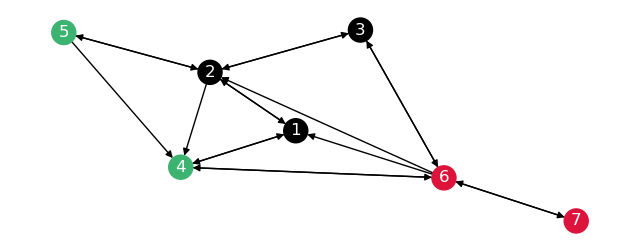

In [3]:
n_sparse = [1, 2, 3]
partitions = {
    "G_s": {"nodes": n_sparse, "color": "black", "subgraph": G.subgraph(n_sparse)},
    "G_1": {"nodes": [4, 5], "color": "mediumseagreen"},
    "G_2": {"nodes": [6, 7], "color": "crimson"},
}
for name, part in partitions.items():
    if "subgraph" not in part:
        # subgraph for all edges from or to nodes in partition
        part["subgraph"] = G.edge_subgraph(
            [(u, v) for u, v in G.edges if u in part["nodes"] or v in part["nodes"]]
        )
    part["nodelist"] = part["subgraph"].nodes
    for node in part["nodes"]:
        G.nodes[node]["partition"] = part["color"]

nx.draw(G, with_labels=True, node_color=[G.nodes[n]["partition"] for n in G.nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G),
        ax=plt.figure(figsize=(8, 3)).gca(),
        )

To check the subgraphs are correct, draw these separately.

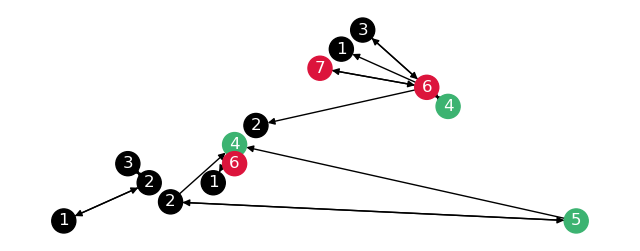

In [4]:
# Copy subgraphs, relabel them, merge them into one graph
composite_graph = nx.DiGraph()
for name, part in partitions.items():
    subgraph = part["subgraph"].copy()
    subgraph = nx.relabel_nodes(subgraph, {n: f"{name}_{n}" for n in subgraph.nodes})
    composite_graph = nx.compose(composite_graph, subgraph)
nx.draw(
    composite_graph,
    node_color=[composite_graph.nodes[n]["partition"] for n in composite_graph.nodes],
    with_labels=True,
    font_color="white",
    labels={n: n.split("_")[-1] for n in composite_graph.nodes},
    pos=nx.planar_layout(composite_graph),
    ax=plt.figure(figsize=(8, 3)).gca(),
)

## Distance calculation

To make the restricted calculation we use two passes of Dijsktra's algorithm.
One pass where it is only possible to leave the sparse graph and one
pass where it is only possible to enter the sparse graph.
Going between two partitions is always prohibited.

### 1. Leaving

Calculate all-pairs shortest paths on graph where we cut the edges that lead us
outside a partition. This way we find all the shortest paths on the sparse graph, to
one partition and inside all the partitions, without exiting. Also the edges between
two different partitions are all cut.

### 2. Entering

Analogous to the first pass, but now we cut the edges that lead us into a partition.
Here we will find the paths from partition nodes to the sparse graph nodes.

For finding the shortest paths we could use
:func:`nx.floyd_warshall_predecessor_and_distance`, but as we'll use this approach
for larger graphs, we'll use :func:`scipy.sparse.csgraph.dijkstra`.

We will convert the graph to a sparse representation (csr) and filter out the
concerning edges.

In [5]:
# sorted node order (names)
node_order = list(sorted(G.nodes))
# node_order indices
node_order_indices = list(range(len(node_order)))
# filtered indices: sparse/partition
n_sparse_indices = [node_order.index(n) for n in n_sparse]
part_name_order = [name for name in partitions.keys() if name != "G_s"]
n_partition_indices_separate = [
    [node_order.index(n) for n in partitions[name]["nodes"]] for name in part_name_order
]
n_partition_indices = [n for part in n_partition_indices_separate for n in part]
# Semipermeable graphs
G_leaving = G.copy()
# Construct Compressed Sparse Row matrix
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html
G_leaving = nx.to_scipy_sparse_array(G_leaving, nodelist=node_order, format="coo")
data, row, col = G_leaving.data, G_leaving.row, G_leaving.col

# Remove edges between different partitions
# (col, row in separate n_partition_indices_separate)
for n_ind_1, n_ind_2 in combinations(n_partition_indices_separate, 2):
    mask = np.logical_and(np.isin(row, n_ind_1), np.isin(col, n_ind_2))
    mask = np.logical_or(mask,
                         np.logical_and(np.isin(row, n_ind_2), np.isin(col, n_ind_1)))
    data, row, col = data[~mask], row[~mask], col[~mask]
G_entering = (data, (row, col))

# Remove edges from partition to sparse
mask = np.logical_and(np.isin(row, n_partition_indices),
                      np.isin(col, n_sparse_indices))
data, row, col = data[~mask], row[~mask], col[~mask]
G_leaving = csr_matrix((data, (row, col)), shape=(len(node_order), len(node_order)))
# Remove edges from sparse to partition
data, (row, col) = G_entering
mask = np.logical_and(np.isin(row, n_sparse_indices),
                      np.isin(col, n_partition_indices))
data, row, col = data[~mask], row[~mask], col[~mask]
G_entering = csr_matrix((data, (row, col)), shape=(len(node_order), len(node_order)))


This will make the graph break up like so:

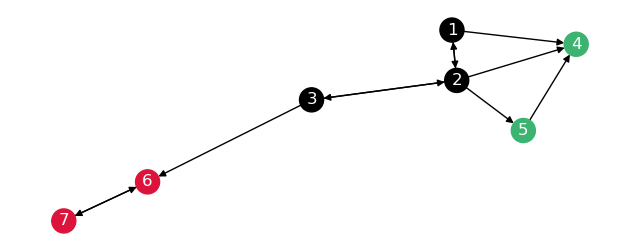

In [6]:
G_leaving_nx = nx.from_scipy_sparse_array(G_leaving, create_using=nx.DiGraph)
G_leaving_nx = nx.relabel_nodes(G_leaving_nx,
                                {i: n for i, n in enumerate(node_order)})
nx.draw(G_leaving_nx,
        with_labels=True,
        node_color=[G.nodes[n]["partition"] for n in G.nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G_leaving_nx),
        ax=plt.figure(figsize=(8, 3)).gca(),
        )

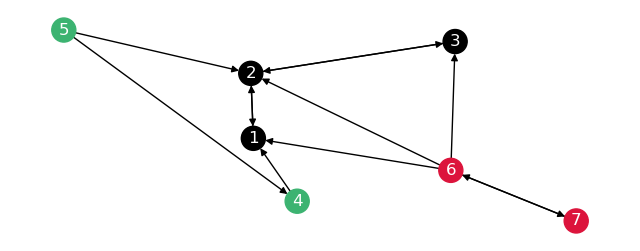

In [7]:
G_entering_nx = nx.from_scipy_sparse_array(G_entering, create_using=nx.DiGraph)
G_entering_nx = nx.relabel_nodes(G_entering_nx,
                                 {i: n for i, n in enumerate(node_order)})
nx.draw(G_entering_nx,
        with_labels=True,
        node_color=[G.nodes[n]["partition"] for n in G.nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G_entering_nx),
        ax=plt.figure(figsize=(8, 3)).gca(),
        )

The distances on both these graphs are the following:

In [8]:
# Calculate distances on this graph
dist_leaving, pred_leaving = dijkstra(G_leaving, directed=True,
                                      return_predecessors=True)
dist_entering, pred_entering = dijkstra(G_entering, directed=True,
                                        return_predecessors=True)

display(pd.DataFrame(dist_leaving, index=node_order, columns=node_order),
        pd.DataFrame(dist_entering, index=node_order, columns=node_order))

,1,2,3,4,5,6,7
1,0.0,1.0,2.0,1.0,2.0,4.0,5.0
2,1.0,0.0,1.0,1.0,1.0,3.0,4.0
3,2.0,1.0,0.0,2.0,2.0,2.0,3.0
4,inf,inf,inf,0.0,inf,inf,inf
5,inf,inf,inf,4.0,0.0,inf,inf
6,inf,inf,inf,inf,inf,0.0,1.0
7,inf,inf,inf,inf,inf,1.0,0.0


,1,2,3,4,5,6,7
1,0.0,1.0,2.0,inf,inf,inf,inf
2,1.0,0.0,1.0,inf,inf,inf,inf
3,2.0,1.0,0.0,inf,inf,inf,inf
4,1.0,2.0,3.0,0.0,inf,inf,inf
5,2.0,1.0,2.0,4.0,0.0,inf,inf
6,1.0,2.0,2.0,inf,inf,0.0,1.0
7,2.0,3.0,3.0,inf,inf,1.0,0.0


## Merge results

We can merge the distances and predecessors taking the minimum of the two distances.

In [9]:
def colored_predecessors(preds, graph=G, node_order=node_order,
                         node_order_indices=node_order_indices):
    return pd.DataFrame(preds, index=node_order_indices,
                        columns=node_order_indices).style. \
        applymap(lambda x: f"color: {graph.nodes[node_order[x]]['partition']}"
    if x != -9999 else "")

In [10]:
min_mask = dist_leaving < dist_entering
dist_le = dist_entering.copy()
pred_le = pred_entering.copy()
dist_le[min_mask], pred_le[min_mask] = dist_leaving[min_mask], pred_leaving[min_mask]

display(pd.DataFrame(dist_le, index=node_order, columns=node_order),
        colored_predecessors(pred_le))

,1,2,3,4,5,6,7
1,0.0,1.0,2.0,1.0,2.0,4.0,5.0
2,1.0,0.0,1.0,1.0,1.0,3.0,4.0
3,2.0,1.0,0.0,2.0,2.0,2.0,3.0
4,1.0,2.0,3.0,0.0,inf,inf,inf
5,2.0,1.0,2.0,4.0,0.0,inf,inf
6,1.0,2.0,2.0,inf,inf,0.0,1.0
7,2.0,3.0,3.0,inf,inf,1.0,0.0


,0,1,2,3,4,5,6
0,-9999,0,1,0,1,2,5
1,1,-9999,1,1,1,2,5
2,1,2,-9999,1,1,2,5
3,3,0,1,-9999,-9999,-9999,-9999
4,1,4,1,4,-9999,-9999,-9999
5,5,0,5,-9999,-9999,-9999,5
6,5,0,5,-9999,-9999,6,-9999


Now we know all the distances and paths if we only allow crossing to/from the
sparsified graph once. The lower right corner of the matrices is still empty, as
these are the paths between the partitions, which need to cross twice.

## Fill up distances

For these all we will need to find the minimum of

$$ d_{ij} = \min_{k_n \in V_s\cup V_n, l_m \in V_s\cup V_m} \left(d_{ik} + d_{kl} +
d_{lj}\right), \quad i \in V_n \Leftrightarrow j \in V_m$$

and the corresponding predecessor. But as we already now all the paths $d_{ik} +
d_{kl}$ entering, and $d_{kl} + d_{lj}$ leaving, we can reduce the search to one
node $k_n$ or $l_m$.

We will go with $k_n$.


In [11]:
n_partition_intersect_indices = [
    list(set(n_sparse).intersection(partitions[name]["nodelist"]))
    for name in part_name_order
]
n_partition_intersect_indices = [
    [node_order.index(n) for n in part_indices]
    for part_indices in n_partition_intersect_indices
]

# Loop, for didactic purposes
# for part_idx, part_intersect in zip(n_partition_indices_separate,
#                                     n_partition_intersect_indices):
#     for i in part_idx:
#         for j in n_partition_indices:
#             if i == j:
#                 continue
#             # distances from i to j, over all possible k in part_intersect
#             dists = dist_le[i, part_intersect] + dist_le[part_intersect, j]
#             # index of minimum distance for predecessor
#             min_idx = np.argmin(dists)
#             if dists[min_idx] >= dist_le[i, j]:
#                 continue
#             dist_le[i, j] = dists[min_idx]
#             pred_le[i, j] = pred_le[part_intersect[min_idx], j]

dist_step = np.full_like(dist_le, np.inf)
pred_step = np.full_like(pred_le, -9999)

# Vectorized - numpy broadcasting
for part_idx, part_intersect in zip(n_partition_indices_separate,
                                    n_partition_intersect_indices):
    # Add distances from i in part_idx to all j in n_partition_indices
    # to the same j to all k in n_partition_indices
    # There is a different amount of i-j than j-k, calculate all combinations
    # and then mask out the invalid ones
    # add to a new dimension
    dists = dist_le[np.ix_(part_idx, part_intersect)][:, :, np.newaxis] + \
            dist_le[np.ix_(part_intersect, n_partition_indices)][np.newaxis, :, :]
    # get index of minimum distance for predecessor, use new axis
    min_idx = np.argmin(dists, axis=1)

    # write minima into dist_step
    dist_step[np.ix_(part_idx, n_partition_indices)] = dists[
        np.arange(dists.shape[0])[:, np.newaxis], min_idx, np.arange(
            dists.shape[-1])]

    # min_mask = dists[np.arange(dists.shape[0])[:, np.newaxis], min_idx, np.arange(
    #     dists.shape[-1])] < dist_le[np.ix_(part_idx, n_partition_indices)]
    # print(min_mask)

    # write predecessors into pred_step
    # predecessor i-k is the same as predecessor k-j
    # into pred_step, write the predecessor of k-j
    for n_p, i in enumerate(part_idx):
        for m_p, j in enumerate(n_partition_indices):
            if i == j:
                continue
            pred_step[i, j] = pred_le[part_intersect[min_idx[n_p, m_p]], j]
    # the same as vectorized
    # overwrite part_intersect with the index of the minimum distance for every part_idx
    # print(min_idx, part_intersect)
    # part_intersect = np.take(part_intersect, min_idx, axis=0)
    # print(part_intersect)
    #
    # print(pred_step[np.ix_(part_idx, n_partition_indices)])
    # # print(pred_le[part_intersect])
    # pred_intersect = np.take(pred_le, part_intersect, axis=0)
    # print(pred_intersect)
    # pred_step[np.ix_(part_idx, n_partition_indices)] = \
    #     pred_le[part_intersect]

mask = dist_step < dist_le
dist_le = np.where(
    mask,
    dist_step,
    dist_le
)
pred_le = np.where(
    mask,
    pred_step,
    pred_le
)


display(pd.DataFrame(dist_le, index=node_order, columns=node_order).style. \
        background_gradient(cmap='Blues').format(precision=0),
        pd.DataFrame(dist_step, index=node_order, columns=node_order).style. \
        background_gradient(cmap='Blues').format(precision=0),
        colored_predecessors(pred_le), colored_predecessors(pred_step))

,1,2,3,4,5,6,7
1,0,1,2,1,2,4,5
2,1,0,1,1,1,3,4
3,2,1,0,2,2,2,3
4,1,2,3,0,3,5,6
5,2,1,2,2,0,4,5
6,1,2,2,2,3,0,1
7,2,3,3,3,4,1,0


/home/carlsonb/miniconda3/envs/OSMnxPyrLab/lib/python3.10/site-packages/pandas/io/formats/style.py:3620: RuntimeWarning: invalid value encountered in scalar subtract
  rng = smax - smin
/home/carlsonb/miniconda3/envs/OSMnxPyrLab/lib/python3.10/site-packages/pandas/io/formats/style.py:3622: RuntimeWarning: invalid value encountered in scalar multiply
  norm = _matplotlib.colors.Normalize(smin - (rng * low), smax + (rng * high))


,1,2,3,4,5,6,7
1,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,2,3,5,6
5,inf,inf,inf,2,2,4,5
6,inf,inf,inf,2,3,4,5
7,inf,inf,inf,3,4,5,6


,0,1,2,3,4,5,6
0,-9999,0,1,0,1,2,5
1,1,-9999,1,1,1,2,5
2,1,2,-9999,1,1,2,5
3,3,0,1,-9999,1,2,5
4,1,4,1,1,-9999,2,5
5,5,0,5,0,1,-9999,5
6,5,0,5,0,1,6,-9999


,0,1,2,3,4,5,6
0,-9999,-9999,-9999,-9999,-9999,-9999,-9999
1,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2,-9999,-9999,-9999,-9999,-9999,-9999,-9999
3,-9999,-9999,-9999,-9999,1,2,5
4,-9999,-9999,-9999,1,-9999,2,5
5,-9999,-9999,-9999,0,1,-9999,5
6,-9999,-9999,-9999,0,1,2,-9999


In [12]:
print(min_idx[np.newaxis, :].shape)
print(min_idx.shape)

(1, 2, 4)
(2, 4)


And there we already got our result. In this case the only difference results
through the edge between $6$ and $4$, which is restricted. The shortest path
differences are the following:

In [13]:
display(pd.DataFrame(
    dist_le - dijkstra(nx.to_scipy_sparse_array(G, nodelist=list(G.nodes)),
                       directed=True,
                       return_predecessors=False),
    index=node_order, columns=node_order).style. \
        format(precision=1).background_gradient(cmap='Reds'))

,1,2,3,4,5,6,7
1,0.0,0.0,0.0,0.0,0.0,1.5,1.5
2,0.0,0.0,0.0,0.0,0.0,0.5,0.5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.5,3.5
5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
6,0.0,0.0,0.0,0.5,0.0,0.0,0.0
7,0.0,0.0,0.0,0.5,0.0,0.0,0.0


To see a difference traversing the sparse graph, we will look at another example
using the implementation of the algorithm in the package.

## Second Example

With the above described algorithm, the method
[`shortest_paths_restricted()`](shortest_paths_restricted) is implemented, see
[Implementation](#implementation). It takes a partitioner as the input and returns the
distance matrix and the predecessor matrix.

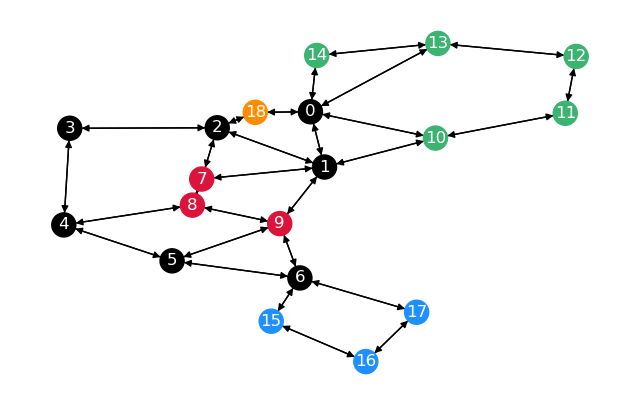

In [14]:
# Create planar graph, similar to a street network
G_2 = nx.DiGraph(nx.Graph(
    [
        (10, 11, {"weight": 1}),
        (11, 12, {"weight": 1}),
        (12, 13, {"weight": 1}),
        (13, 0, {"weight": 1.5}),
        (13, 14, {"weight": 1}),
        (14, 0, {"weight": 1}),
        (0, 10, {"weight": 1}),
        (0, 1, {"weight": 1}),
        (10, 1, {"weight": 1}),
        (1, 2, {"weight": 1}),
        (2, 3, {"weight": 1}),
        (3, 4, {"weight": 1.5}),
        (4, 5, {"weight": 1}),
        (5, 9, {"weight": 1}),
        (5, 6, {"weight": 1}),
        (7, 2, {"weight": 1}),
        (8, 7, {"weight": 0.5}),
        (7, 1, {"weight": 1}),
        (8, 9, {"weight": 0.7}),
        (6, 9, {"weight": 1}),
        (8, 4, {"weight": 1}),
        (9, 1, {"weight": 1}),
        (0, 18, {"weight": 0.4}),
        (18, 2, {"weight": 0.4}),
        (6, 15, {"weight": 0.8}),
        (15, 16, {"weight": 1}),
        (16, 17, {"weight": 1}),
        (17, 6, {"weight": 1}),
    ]
))
n_sparse = [0, 1, 2, 3, 4, 5, 6]
partitions = {
    "sparsified":
        {"nodes": n_sparse, "color": "black", "subgraph": G_2.subgraph(n_sparse)},
    "G_r": {"nodes": [7, 8, 9], "color": "crimson"},
    "G_g": {"nodes": [10, 11, 12, 13, 14], "color": "mediumseagreen"},
    "G_b": {"nodes": [15, 16, 17], "color": "dodgerblue"},
    "G_o": {"nodes": [18], "color": "darkorange"},
}
for name, part in partitions.items():
    if "subgraph" not in part:
        # subgraph for all edges from or to nodes in partition
        part["subgraph"] = G_2.edge_subgraph(
            [(u, v) for u, v in G_2.edges if u in part["nodes"] or v in part["nodes"]]
        )
    part["nodelist"] = part["subgraph"].nodes
    for node in part["nodes"]:
        G_2.nodes[node]["partition"] = part["color"]

nx.draw(G_2, with_labels=True, node_color=[G_2.nodes[n]["partition"] for n in G_2
        .nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G_2),
        ax=plt.figure(figsize=(8, 5)).gca(),
        )

Two notes to this graph. The distance between $0$ and $2$ is $0.8$ on the unrestricted
graph $0 \overset{0.4}{\rightarrow} 18 \overset{0.4}{\rightarrow} 2$, instead of $2$
with restrictions $0 \overset{1}{\rightarrow} 1 \overset{1}{\rightarrow} 2$.
Getting from $1$ to $6$ would also be far shorter than taking the shortest path on the
sparsified graph. The calculation using :func:`shortest_paths_restricted(G_2)
<superblockify.metrics.distances.shortest_paths_restricted>` gives the following
results.

In [15]:
from superblockify.metrics.distances import shortest_paths_restricted

node_order_2 = list(range(len(G_2.nodes)))
dist, pred = shortest_paths_restricted(G_2, partitions, weight="weight",
                                       node_order=node_order_2)
display(pd.DataFrame(dist, index=node_order_2, columns=node_order_2).style. \
        set_table_attributes('style="font-size: 12px"').format(precision=1)
        .background_gradient(cmap='Blues'),
        colored_predecessors(pred, G_2, node_order=node_order_2,
                             node_order_indices=node_order_2). \
        set_table_attributes('style="font-size: 10px"'))

/home/carlsonb/miniconda3/envs/OSMnxPyrLab/lib/python3.10/site-packages/osmnx/projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


2023-04-10 14:48:46,612 |     INFO | __init__.py:13 | superblockify version 0.0.0
2023-04-10 14:48:46,616 |    DEBUG | distances.py:610 | Calculating 2 semipermeable distance matrices with 2 workers.


Calculating distance matrices: 100%|██████████| 2.00/2.00 [00:00<00:00, 1.81kit/s]

2023-04-10 14:48:46,640 |    DEBUG | distances.py:629 | Finished calculating distance matrices in 0:00:00.023479. Combining the results.
2023-04-10 14:48:46,642 |    DEBUG | distances.py:697 | Finished filling up paths in 0:00:00.000570.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,1.0,2.0,3.0,4.5,5.5,6.5,2.0,2.5,2.0,1.0,2.0,2.5,1.5,1.0,7.3,8.3,7.5,0.4
1,1.0,0.0,1.0,2.0,3.5,4.5,5.5,1.0,1.5,1.0,1.0,2.0,3.0,2.5,2.0,6.3,7.3,6.5,1.4
2,2.0,1.0,0.0,1.0,2.5,3.5,4.5,1.0,1.5,2.0,2.0,3.0,4.0,3.5,3.0,5.3,6.3,5.5,0.4
3,3.0,2.0,1.0,0.0,1.5,2.5,3.5,2.0,2.5,3.0,3.0,4.0,5.0,4.5,4.0,4.3,5.3,4.5,1.4
4,4.5,3.5,2.5,1.5,0.0,1.0,2.0,1.5,1.0,1.7,4.5,5.5,6.5,6.0,5.5,2.8,3.8,3.0,2.9
5,5.5,4.5,3.5,2.5,1.0,0.0,1.0,2.2,1.7,1.0,5.5,6.5,7.5,7.0,6.5,1.8,2.8,2.0,3.9
6,6.5,5.5,4.5,3.5,2.0,1.0,0.0,2.2,1.7,1.0,6.5,7.5,8.5,8.0,7.5,0.8,1.8,1.0,4.9
7,2.0,1.0,1.0,2.0,1.5,2.2,2.2,0.0,0.5,1.2,2.0,3.0,4.0,3.5,3.0,3.0,4.0,3.2,1.4
8,2.5,1.5,1.5,2.5,1.0,1.7,1.7,0.5,0.0,0.7,2.5,3.5,4.5,4.0,3.5,2.5,3.5,2.7,1.9
9,2.0,1.0,2.0,3.0,1.7,1.0,1.0,1.2,0.7,0.0,2.0,3.0,4.0,3.5,3.0,1.8,2.8,2.0,2.4


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-9999,0,1,2,3,4,5,1,7,1,0,10,13,0,0,6,15,6,0
1,1,-9999,1,2,3,4,5,1,7,1,1,10,11,0,0,6,15,6,0
2,1,2,-9999,2,3,4,5,2,7,1,1,10,11,0,0,6,15,6,2
3,1,2,3,-9999,3,4,5,2,4,1,1,10,11,0,0,6,15,6,2
4,1,2,3,4,-9999,4,5,8,4,8,1,10,11,0,0,6,15,6,2
5,1,2,3,4,5,-9999,5,8,9,5,1,10,11,0,0,6,15,6,2
6,1,2,3,4,5,6,-9999,8,9,6,1,10,11,0,0,6,15,6,2
7,1,7,7,2,8,9,9,-9999,7,8,1,10,11,0,0,6,15,6,2
8,1,7,7,4,8,9,9,8,-9999,8,1,10,11,0,0,6,15,6,2
9,1,9,1,2,8,9,9,8,9,-9999,1,10,11,0,0,6,15,6,0


At first glance the predecessor matrix looks correct. The yellow $18$ is only
predecessor coming from itself. Also for the red partition $7$, $8$, $9$ we see that
they are only being visited for the columns or rows corresponding to themselves. The
same can be said for the other partitions. When going from or to sparsified nodes, no
colorful nodes are visited.

From here one could reconstruct the shortest paths. A direct implementation
for a single path would be the following.

In [16]:
def reconstruct_path(pred, start, end):
    """Reconstruct path from predecessor matrix."""
    if start == end:
        return []
    prev = pred[start]
    curr = prev[end]
    path = [end, curr]
    while curr != start:
        curr = prev[curr]
        path.append(curr)
    return list(reversed(path))

In [17]:
reconstruct_path(pred, 0, 2), reconstruct_path(pred, 0, 6), \
    reconstruct_path(pred, 14, 7), reconstruct_path(pred, 12, 16), \
    reconstruct_path(pred, 7, 18)

([0, 1, 2],
 [0, 1, 2, 3, 4, 5, 6],
 [14, 0, 1, 7],
 [12, 11, 10, 1, 2, 3, 4, 5, 6, 15, 16],
 [7, 2, 18])

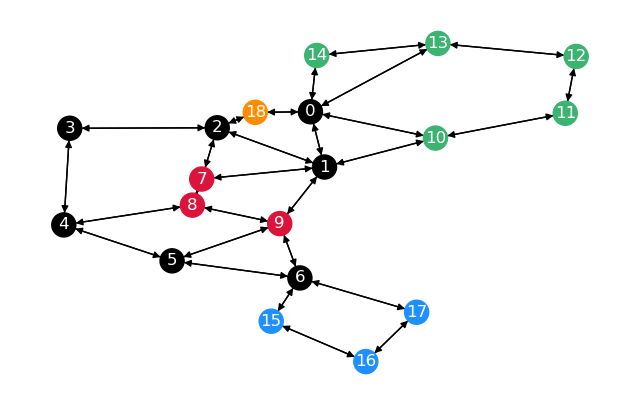

In [18]:
nx.draw(G_2, with_labels=True, node_color=[G_2.nodes[n]["partition"] for n in G_2
        .nodes],
        font_color="white",
        pos=nx.kamada_kawai_layout(G_2),
        ax=plt.figure(figsize=(8, 5)).gca(),
        )

To finish, the difference between the unrestricted and restricted graph distances.

In [19]:
display(pd.DataFrame(
    dist - dijkstra(nx.to_scipy_sparse_array(G_2, nodelist=node_order_2),
                    directed=True,
                    return_predecessors=False),
    index=node_order_2, columns=node_order_2).style. \
        format(precision=1).background_gradient(cmap='Reds'). \
        set_table_attributes('style="font-size: 12px"'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.0,0.0,1.2,1.2,1.2,2.5,3.5,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,3.5,0.0
1,0.0,0.0,0.0,0.0,1.0,2.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,3.5,0.0
2,1.2,0.0,0.0,0.0,0.0,0.5,1.5,0.0,0.0,0.0,0.2,0.2,0.7,1.2,1.2,1.5,1.5,1.5,0.0
3,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.7,1.2,1.2,0.0,0.0,0.0,0.0
4,1.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.2,1.2,0.0,0.0,0.0,0.0
5,2.5,2.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,2.5,2.5,2.5,2.5,0.0,0.0,0.0,0.5
6,3.5,3.5,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,3.5,3.5,3.5,3.5,0.0,0.0,0.0,1.5
7,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0
8,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
